In [1]:
import requests

r = requests.get("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt")
readme = r.text
print (readme)

README FILE FOR DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 
Version 3.26

--------------------------------------------------------------------------------
How to cite:

Note that the GHCN-Daily dataset itself now has a DOI (Digital Object Identifier)
so it may be relevant to cite both the methods/overview journal article as well 
as the specific version of the dataset used.

The journal article describing GHCN-Daily is:
Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview 
of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric 
and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

To acknowledge the specific version of the dataset used, please cite:
Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3. [indicate subset used following decimal

In [2]:
i = requests.get("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt")
inventory_txt = i.text
print(inventory_txt[:137])

ACW00011604  17.1167  -61.7833 TMAX 1949 1949
ACW00011604  17.1167  -61.7833 TMIN 1949 1949
ACW00011604  17.1167  -61.7833 PRCP 1949 1949


In [3]:
s = requests.get("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt")
stations_txt = s.text
print(stations_txt[:200])

ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       
ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    
AE000041196  25.3330   55.51


In [4]:
with open("inventory.txt", "w") as inventory_file:
    inventory_file.write(inventory_txt)

In [5]:
with open("stations.txt", "w",  encoding = 'utf-8') as stations_file:
    stations_file.write(stations_txt)

In [6]:
from collections import namedtuple

Inventory = namedtuple("Inventory", ['station', 'latitude', 'longtitude', 'element', 'start', 'end'])

inventory = [Inventory(x[0:11], float(x[12:20]), float(x[21:30]), x[31:35], int(x[36:40]), int(x[41:45])) 
             for x in inventory_txt.split("\n") if x.startswith('RSM00036')]
for line in inventory[:5]:
    print (line)

Inventory(station='RSM00036020', latitude=52.5, longtitude=80.2, element='TMAX', start=1948, end=2018)
Inventory(station='RSM00036020', latitude=52.5, longtitude=80.2, element='TMIN', start=1948, end=2018)
Inventory(station='RSM00036020', latitude=52.5, longtitude=80.2, element='PRCP', start=1936, end=2018)
Inventory(station='RSM00036020', latitude=52.5, longtitude=80.2, element='SNWD', start=1973, end=2018)
Inventory(station='RSM00036020', latitude=52.5, longtitude=80.2, element='TAVG', start=1948, end=2018)


In [7]:
inventory_temps = [x for x in inventory if x.element in ['TMIN', 'TMAX'] and x.end >= 2016 and x.start < 1945]
inventory_temps[:2]

[Inventory(station='RSM00036034', latitude=51.5, longtitude=81.2167, element='TMAX', start=1936, end=2020),
 Inventory(station='RSM00036034', latitude=51.5, longtitude=81.2167, element='TMIN', start=1936, end=2020)]

In [8]:
#Kyzel's coordinates
latitude, longtitude = 51.73, 94.52
inventory_temps.sort(key=lambda x: abs(latitude - x.latitude) + abs(longtitude - x.longtitude))
inventory_temps[:2]

[Inventory(station='RSM00036096', latitude=51.72, longtitude=94.5, element='TMAX', start=1943, end=2020),
 Inventory(station='RSM00036096', latitude=51.72, longtitude=94.5, element='TMIN', start=1943, end=2020)]

In [9]:
#Перебор станций
station_id = 'RSM00036096'
Station = namedtuple('Station', ['station_id', 'latitude', 'longtitude', 'elevation', 'state', 'name', 'start', 'end'])
stations = [(x[0:11], float(x[12:20]), float(x[21:30]), float(x[31:37]), x[38:40].strip(), x[41:71].strip())
            for x in stations_txt.split("\n") if x.startswith(station_id)]
# print(stations)
# print(len(stations), type(stations))

station = Station(*stations[0] + (inventory_temps[0].start, inventory_temps[0].end))
print(station)

Station(station_id='RSM00036096', latitude=51.72, longtitude=94.5, elevation=626.0, state='', name='KYZYL', start=1943, end=2020)


In [22]:
#Получение ежедненвых данных для станции
r = requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{}.dly'.format(station.station_id))
weather = r.text
with open('weather_{}.txt'.format(station), 'w') as weather_file:
    weather_file.write(weather)
print(weather[:540])

RSM00036096194310TMAX  202  r  188  r  168  r  150  r   82  r   84  r  115  r  166  r  126  r  159  r  190  r  164  r  117  r    3  r    5  r   28  r   48  r   22  r   53  r   69  r   25  r   10  r  -10  r  -50  r  -45  r  -39  r  -25  r   22  r  -38  r    5  r  -51  r
RSM00036096194310TMIN   15  r   12  r   84  r   13  r   30  r  -41  r    9  r  -16  r   28  r   42  r  -17  r  -17  r   -4  r  -77  r  -54  r  -96  r -103  r  -44  r  -69  r  -59  r  -95  r  -55  r  -89  r -142  r -161  r -152  r -103  r -104  r -108  r -106  r -160  r



In [19]:
def parse_line(line):
    if not line:
        return None
    record, temperature_string = (line[:11], int(line[11:15]), int(line[15:17]), line[17:21]), line[21:]
    if len(temperature_string) < 248:
        raise ValueError("String not long enough {}, {}".format(temperature_string, len(line)))
    values = [float(temperature_string[i:i +5])/10 for i in range(0, 248, 8) if not temperature_string[i:i + 5].startswith("-9999")]
    count = len(values)
    tmax = round(max(values), 1)
    tmin = round(min(values), 1)
    mean = round(sum(values)/count, 1)
    
    return record + (tmax, tmin, mean, count)

In [23]:
parse_line(weather[:270])

('RSM00036096', 1943, 10, 'TMAX', 20.2, -5.1, 6.3, 31)

In [24]:
#Получение ежедненвых данных для  из УЧЕБНИКА!!!!!!!!!!
r = requests.get('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{}.dly'.format('USC00110338'))
weather1 = r.text
with open('weather_{}.txt'.format('USC00110338'), 'w') as weather_file:
    weather_file.write(weather1)
print(weather1[:540])

USC00110338189301TMAX  -11  6  -44  6 -139  6  -83  6 -100  6  -83  6  -72  6  -83  6  -33  6 -178  6 -150  6 -128  6 -172  6 -200  6 -189  6 -150  6 -106  6  -61  6  -94  6  -33  6  -33  6  -33  6  -33  6    6  6  -33  6  -78  6  -33  6   44  6  -89 I6  -22  6    6  6
USC00110338189301TMIN  -50  6 -139  6 -250  6 -144  6 -178  6 -228  6 -144  6 -222  6 -178  6 -250  6 -200  6 -206  6 -267  6 -272  6 -294  6 -294  6 -311  6 -200  6 -233  6 -178  6 -156  6  -89  6 -200  6 -194  6 -194  6 -178  6 -200  6  -33 I6 -156  6 -139  6 -167  6



In [25]:
parse_line(weather1[:270])

('USC00110338', 1893, 1, 'TMAX', 4.4, -20.0, -7.8, 31)

In [26]:
weather_data = [parse_line(x) for x in weather.split("\n") if x]
len(weather_data)
weather_data[:10]

[('RSM00036096', 1943, 10, 'TMAX', 20.2, -5.1, 6.3, 31),
 ('RSM00036096', 1943, 10, 'TMIN', 8.4, -16.1, -5.3, 31),
 ('RSM00036096', 1943, 10, 'PRCP', 2.1, 0.0, 0.2, 31),
 ('RSM00036096', 1943, 10, 'TAVG', 12.3, -11.2, -0.3, 31),
 ('RSM00036096', 1943, 11, 'TMAX', -0.3, -19.8, -11.5, 30),
 ('RSM00036096', 1943, 11, 'TMIN', -7.2, -29.9, -19.6, 30),
 ('RSM00036096', 1943, 11, 'PRCP', 2.8, 0.0, 0.3, 30),
 ('RSM00036096', 1943, 11, 'TAVG', -5.3, -25.7, -15.6, 30),
 ('RSM00036096', 1943, 12, 'TMAX', -14.5, -33.4, -21.2, 31),
 ('RSM00036096', 1943, 12, 'TMIN', -22.7, -39.9, -30.2, 31)]

In [27]:
import sqlite3

conn = sqlite3.connect("weather_data.db")
cursor = conn.cursor()

create_weather = """CREATE TABLE "weather" (
    "id" text NOT NULL,
    "year" integer NOT NULL,
    "month" integer NOT NULL,
    "element" text NOT NULL,
    "max" real,
    "min" real,
    "mean" real,
    "count" integer)"""
cursor.execute(create_weather)
conn.commit()

In [31]:
for record in weather_data:
    cursor.execute("""INSERT into weather (id, year, month, element, max, min, mean, count) values (?,?,?,?,?,?,?,?)""", record)
    conn.commit()

In [33]:
cursor.execute("""SELECT * from weather where element='TMAX' order by year, month""")
tmax_data = cursor.fetchall()
tmax_data[:5]

[('RSM00036096', 1943, 10, 'TMAX', 20.2, -5.1, 6.3, 31),
 ('RSM00036096', 1943, 11, 'TMAX', -0.3, -19.8, -11.5, 30),
 ('RSM00036096', 1943, 12, 'TMAX', -14.5, -33.4, -21.2, 31),
 ('RSM00036096', 1944, 2, 'TMAX', -13.6, -38.7, -23.7, 29),
 ('RSM00036096', 1944, 3, 'TMAX', 4.0, -16.0, -5.8, 31)]

In [34]:
tmax_data = [x for x in weather_data if x[3] == 'TMAX']
tmin_data = [x for x in weather_data if x[3] == 'TMIN']
tmin_data[:5]

[('RSM00036096', 1943, 10, 'TMIN', 8.4, -16.1, -5.3, 31),
 ('RSM00036096', 1943, 11, 'TMIN', -7.2, -29.9, -19.6, 30),
 ('RSM00036096', 1943, 12, 'TMIN', -22.7, -39.9, -30.2, 31),
 ('RSM00036096', 1944, 1, 'TMIN', -34.7, -47.7, -41.2, 31),
 ('RSM00036096', 1944, 2, 'TMIN', -25.9, -46.2, -35.4, 29)]

In [36]:
import pandas as pd
%matplotlib inline

tmax_df = pd.DataFrame(tmax_data, columns=['Station',  "year", "month", "element", "max", "min", "mean", "Days"])
tmin_df = pd.DataFrame(tmin_data, columns=['Station',  "year", "month", "element", "max", "min", "mean", "Days"])

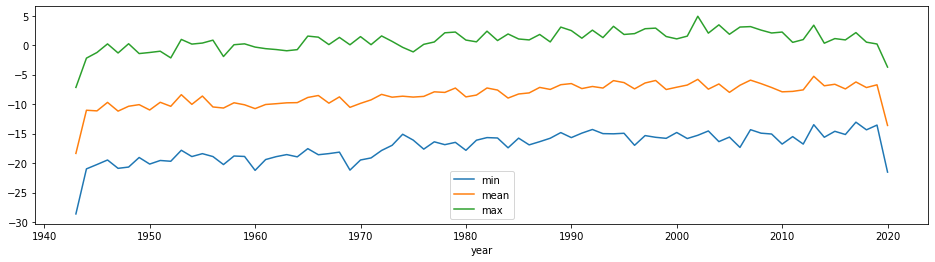

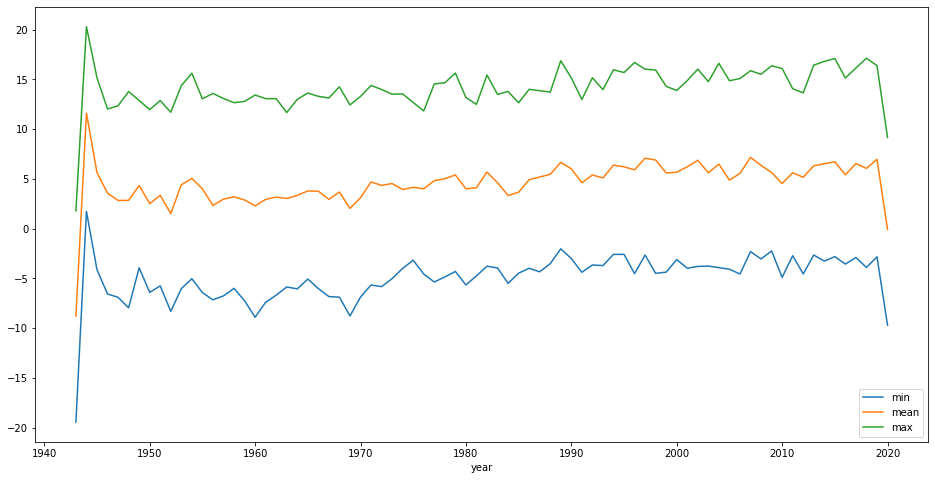

In [43]:
tmin_df[['year', 'min', 'mean', 'max']].groupby('year').mean().plot(kind='line', figsize=(16,4))
tmax_df[['year', 'min', 'mean', 'max']].groupby('year').mean().plot(kind='line', figsize=(16,8))